In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import random
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

%matplotlib inline

# 1. Import and explore the data

In [2]:
df = pd.read_csv('../data/interim/skill_salary_clean.csv')
df.head()

,code,occupation,skill,importance,location,state,annual
0,111011,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,111011,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,111011,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,111011,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,111011,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771830 entries, 0 to 4771829
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   code        int64  
 1   occupation  object 
 2   skill       object 
 3   importance  float64
 4   location    object 
 5   state       object 
 6   annual      float64
dtypes: float64(2), int64(1), object(4)
memory usage: 254.8+ MB


There are 4,771,830 rows and 7 columns. Importance is the numerical measure of each skill. Only importance and salary are numeric values. 

# 2. Categorical features

In [4]:
# Number of unique occupations
occupations = df['occupation'].unique()
df['occupation'].nunique()

788

In [5]:
# List of all unique skills
df['skill'].unique()

array(['Reading Comprehension', 'Active Listening', 'Writing', 'Speaking',
       'Mathematics', 'Science', 'Critical Thinking', 'Active Learning',
       'Learning Strategies', 'Monitoring', 'Social Perceptiveness',
       'Coordination', 'Persuasion', 'Negotiation', 'Instructing',
       'Service Orientation', 'Complex Problem Solving',
       'Operations Analysis', 'Technology Design', 'Equipment Selection',
       'Installation', 'Programming', 'Operations Monitoring',
       'Operation and Control', 'Equipment Maintenance',
       'Troubleshooting', 'Repairing', 'Quality Control Analysis',
       'Judgment and Decision Making', 'Systems Analysis',
       'Systems Evaluation', 'Time Management',
       'Management of Financial Resources',
       'Management of Material Resources',
       'Management of Personnel Resources'], dtype=object)

In [6]:
# Number of unique skills
df['skill'].nunique()

35

In [7]:
# Number of unique locations
locations = df['location'].unique()
df['location'].nunique()

379

There are 35 unique skills, 379 unique locations and 788 unique occupations

# 3. Target feature (annual salary)

In [8]:
# Mean salary across all occupations
all_mean = np.mean(df['annual'])
all_std = np.std(df['annual'])
all_median = np.median(df['annual'])
print('Mean of all salaries: ' + str(round(all_mean)))
print('Standard deviation: ' + str(round(all_std)))

Mean of all salaries: 60962
Standard deviation: 32561


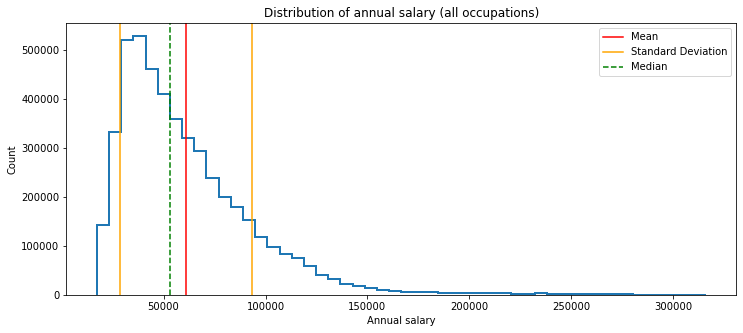

In [9]:
# Annual salary distribution for all occupations, with mean and one standard deviation represented with red and orange lines
# and the median in green
ax, fig = plt.subplots(figsize=(12, 5))
plt.hist(df['annual'], bins=50, histtype='step', linewidth = 2)
plt.axvline(x=all_mean, color='red', label='Mean')
plt.axvline(x=all_mean - all_std, color='orange', label='Standard Deviation')
plt.axvline(x=all_mean + all_std, color='orange')
plt.axvline(x=all_median, linestyle='--', color='green', label='Median')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of annual salary (all occupations)')
plt.legend();

The annual salary distribution is highly skewed to the right, indicating very few earners above $150,000.

## 3.1 Salary distribution of random selection of occuptions

In [10]:
# Select a few (say 15) random occpuations 
np.random.seed(154)
random_numbers=np.empty(15)
random_occupations=[]
for i in range(15):
    random_numbers[i] = np.random.randint(0, len(occupations))
    random_occupations.append(occupations[int(random_numbers[i])])

In [11]:
random_occupations

['Geographic Information Systems Technologists and Technicians',
 'Medical Transcriptionists',
 'Fallers',
 'First-Line Supervisors of Construction Trades and Extraction Workers',
 'Aerospace Engineers',
 'Petroleum Pump System Operators, Refinery Operators, and Gaugers',
 'Industrial Ecologists',
 'Film and Video Editors',
 'Anesthesiologists',
 'Fire Inspectors and Investigators',
 'Government Property Inspectors and Investigators',
 'Education and Childcare Administrators, Preschool and Daycare',
 'Maids and Housekeeping Cleaners',
 'Broadcast Technicians',
 'Landscaping and Groundskeeping Workers']

In [12]:
# Function that plots the salary distributions for a list of occupations
def salary_dist(occupation_list, sharey):
        fig, axes = plt.subplots(nrows=int(len(occupation_list)/3), ncols=3, figsize=(20,10), sharex=True, sharey=sharey)
        plt.subplots_adjust(wspace=0.5, hspace=0.7)
        new_slice = df[['occupation', 'location', 'annual']]
        new_slice = new_slice[~new_slice.duplicated()]
        for name, ax in zip(occupation_list, axes.ravel()):
            new_slice[new_slice['occupation']==name].annual.hist(ax=ax)
            ax.axvline(x=all_mean, color='red', label='Mean')
            ax.set_xlabel('Salary')
            ax.set_ylabel('Count')
            ax.set_title(name);

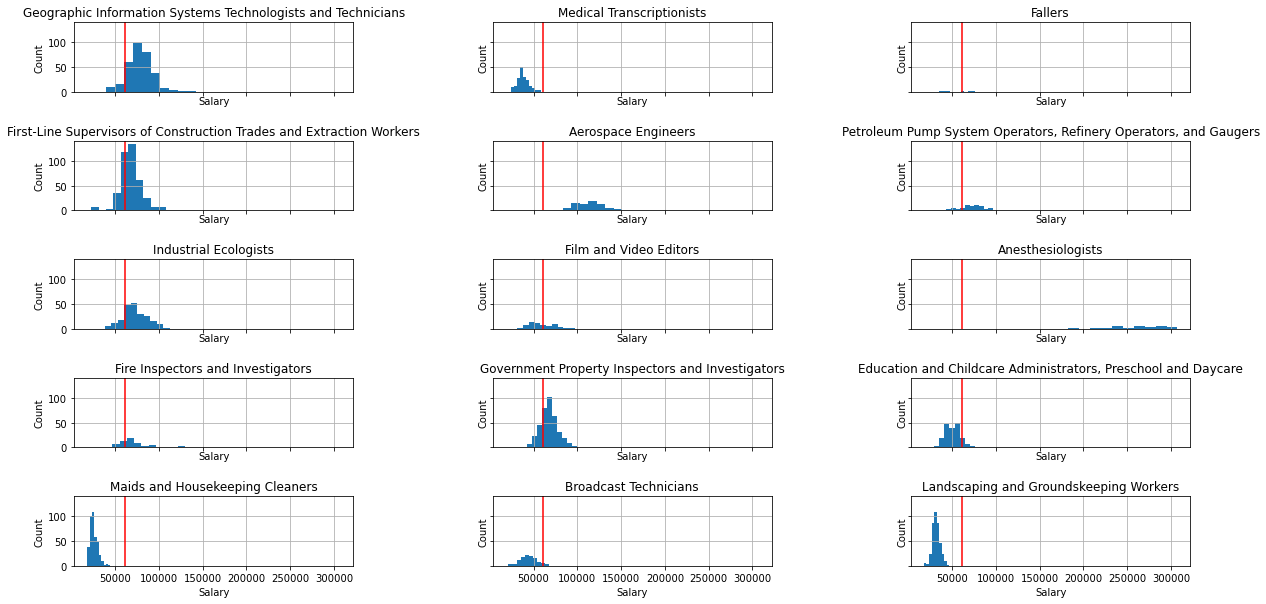

In [13]:
# Plot distributions of a few occupations, using same scale for both x and y axes
salary_dist(random_occupations, True)

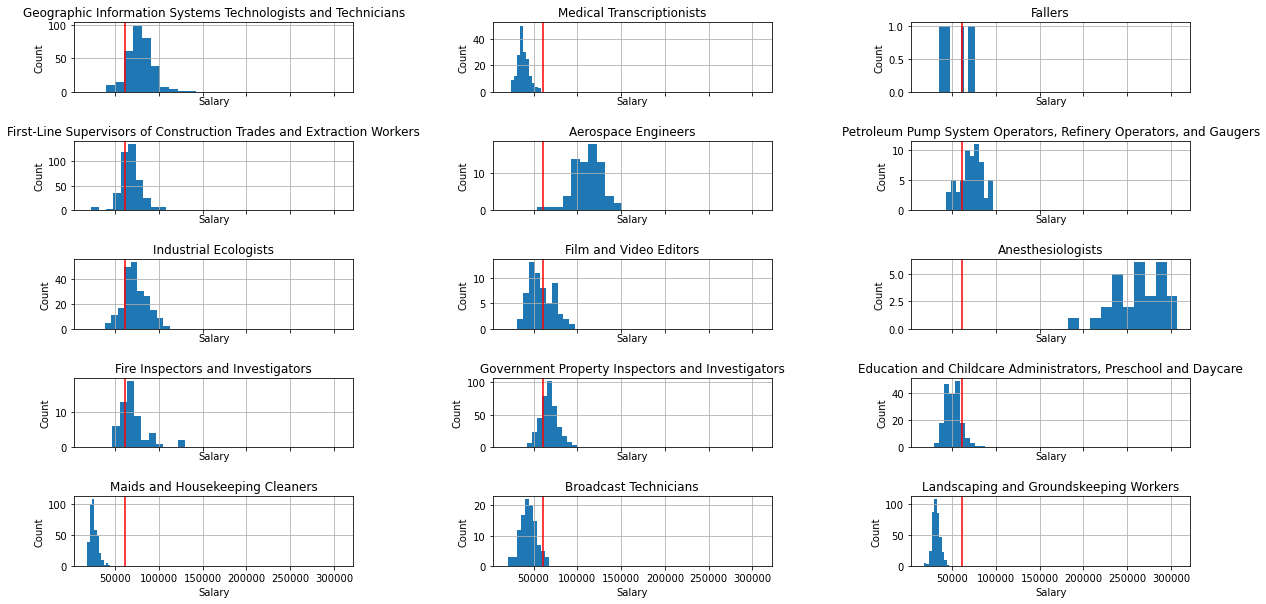

In [14]:
# Plot distributions of a few occupations, not suing same scale for y axis
salary_dist(random_occupations, False)

From the first set of plots, we can see that there are very few Fallers and Anesthesiologists but they each fall on the opposite extreme ends of the salary range (Fallers on the low side and Anesthesiologists towards the hight end). 

Medical Transcriptionists, Maids and Housekeeping Cleaners as well as Landscape workers are among the lowest earners with distributuions fully below the mean of all occupations. 

Aerospace Engineers and Anesthesiologist make well above average where the lowest-earning Anesthesiologist making more than the highest earning Aerospance Engineer!! 

Distributions of the remaining occupations are right around the mean. 

## 3.2 Summary statistics

In [15]:
# Salary statistics for each occupation (the ones from above)
occupation_stats = df.groupby('occupation')['annual'].describe()
occupation_stats.loc[random_occupations]

,count,mean,std,min,25%,50%,75%,max
occupation,,,,,,,,
Geographic Information Systems Technologists and Technicians,11095.0,78383.217666,13850.884546,39910.0,69750.0,78350.0,86550.0,142440.0
Medical Transcriptionists,6300.0,38076.055556,6471.693558,24320.0,34135.0,37285.0,41985.0,58050.0
Fallers,210.0,55420.000000,15626.394828,35480.0,39990.0,54950.0,70880.0,76270.0
First-Line Supervisors of Construction Trades and Extraction Workers,13755.0,68027.938931,11197.446251,22590.0,61410.0,67140.0,73750.0,107870.0
Aerospace Engineers,2485.0,111034.929577,16928.144272,53900.0,100580.0,114120.0,122740.0,151410.0
"Petroleum Pump System Operators, Refinery Operators, and Gaugers",2135.0,71614.918033,12681.587180,43470.0,64600.0,72620.0,80590.0,96510.0
Industrial Ecologists,7595.0,72927.096774,13670.324521,38490.0,63900.0,71630.0,82600.0,112340.0
Film and Video Editors,2135.0,58576.229508,14255.436493,31440.0,46750.0,55930.0,70240.0,97050.0
Anesthesiologists,1015.0,262156.206897,28904.845572,182680.0,240440.0,266440.0,283200.0,307390.0


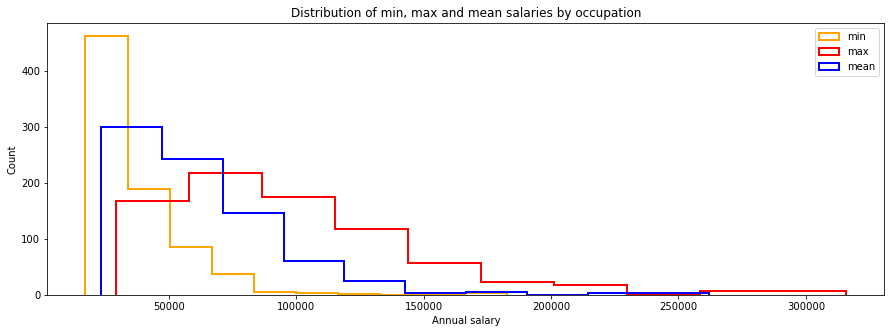

In [16]:
# Distribution of min, max and mean salaries by occupation
fig, ax = plt.subplots(figsize=(15,5))
plt.hist(occupation_stats['min'], histtype='step', linewidth=2, label='min', color='orange')
plt.hist(occupation_stats['max'], histtype='step', linewidth=2, label='max', color='red')
plt.hist(occupation_stats['mean'], histtype='step', linewidth=2, label='mean', color='blue')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of min, max and mean salaries by occupation')
plt.legend();

There is a LOT of overlap of min, max and mean salaries. There are occupations whose maximum earning is very low while we see there are occupations whose minimum annual income is higher than some of the maximum values.

In [17]:
# Salary statistics for each state
state_stats=df.groupby('state')['annual'].describe()
state_stats.head()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
AK,20860.0,72039.530201,31516.526027,24550.0,46557.5,69725.0,90020.0,240630.0
AL,126490.0,55376.516325,31169.355725,17440.0,33020.0,47620.0,67860.0,292110.0
AR,62755.0,53508.499721,29501.426893,19660.0,32930.0,45080.0,65500.0,247020.0
AZ,80570.0,58488.357950,29895.799874,25370.0,36760.0,49890.0,72180.0,279240.0
CA,362565.0,71988.443865,37200.672974,27710.0,42690.0,63020.0,92720.0,302040.0


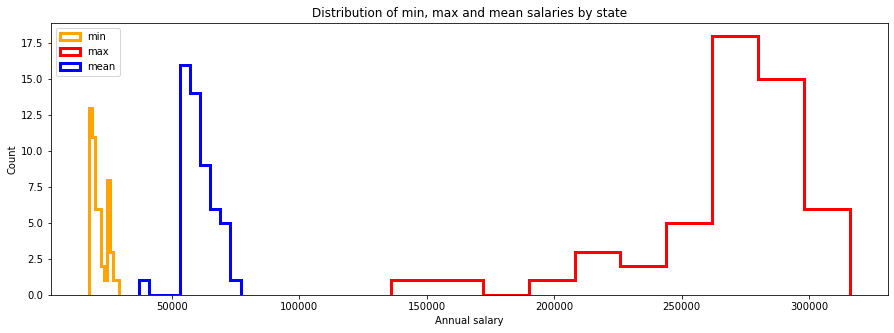

In [18]:
# Distribution of min, max and mean salaries by state
fig, ax = plt.subplots(figsize=(15,5))
plt.hist(state_stats['min'], histtype='step', linewidth=3, label='min', color='orange')
plt.hist(state_stats['max'], histtype='step', linewidth=3, label='max', color='red')
plt.hist(state_stats['mean'], histtype='step', linewidth=3, label='mean', color='blue')
plt.xlabel('Annual salary')
plt.ylabel('Count')
plt.title('Distribution of min, max and mean salaries by state')
plt.legend();

In the minimum, mean and maximum salary distributions by state, there is no overlap like. Maximum salaries for each state clearly are higher than the mean and minimum values for ALL states and minimun values are clearly less than the mean for ALL states. 

In [19]:
# Average income across all occupations, by state
income_average_per_state = df.groupby('state')['annual'].mean()
total_mean=income_average_per_state.mean()

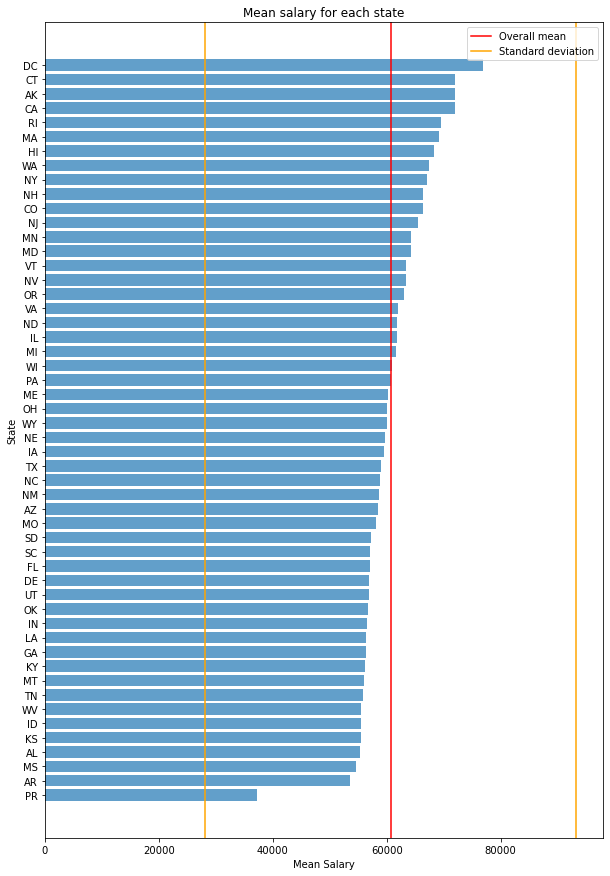

In [20]:
# Bar plot average income across all occupations by state with mean of all income represented with horizontal red line
fig, ax = plt.subplots(figsize=(10,15))
ax.barh(income_average_per_state.sort_values().index, income_average_per_state.sort_values(), alpha=0.7)
ax.axvline(x=total_mean, color='red', label='Overall mean')
ax.axvline(x=total_mean + all_std, color='orange', label='Standard deviation')
ax.axvline(x=total_mean - all_std, color='orange')
ax.set_ylabel('State')
ax.set_xlabel('Mean Salary')
ax.set_title('Mean salary for each state')
ax.legend(loc='upper right');

More states have average salaries below the national average. Puerto Rico has the lowest average by a significant amount below the next lowest average (Arkansas), but all state/territories averages are within one statndard deviation. 

The highest averages belong to District of Columbia at number one, followed by Conneticut, Alaska and California with nearly the same average. 

# 4. Explore features (skills)

In [21]:
# Pivot table so that each skill is a column (variable)
df_pivot = df.pivot_table(values='importance',index=['occupation', 'state', 'annual'],columns='skill').reset_index()
df_pivot = df_pivot.set_index(['occupation'])
df_pivot.head()

skill,state,annual,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
occupation,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,AK,71610.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
Accountants and Auditors,AK,81170.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
Accountants and Auditors,AL,58570.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
Accountants and Auditors,AL,60400.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
Accountants and Auditors,AL,62120.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75


In [22]:
df_pivot.shape

(135989, 37)

In [23]:
df.shape

(4771830, 7)

In [24]:
# Verify that there are 35 skills
df.shape[0]/df_pivot.shape[0]

35.089823441601894

In [25]:
# Skill statistics
df_pivot.describe().T

,count,mean,std,min,25%,50%,75%,max
skill,,,,,,,,
annual,135989.0,61000.738883,32569.962138,17300.00,37350.00,53010.00,76200.00,315830.00
Active Learning,135989.0,3.111376,0.488323,1.88,2.88,3.12,3.50,4.12
Active Listening,135989.0,3.626858,0.444984,2.00,3.19,3.75,4.00,5.00
Complex Problem Solving,135989.0,3.196608,0.502775,1.88,2.88,3.12,3.62,4.38
Coordination,135989.0,3.176050,0.392006,2.00,3.00,3.00,3.44,4.25
Critical Thinking,135989.0,3.500556,0.445744,2.25,3.12,3.62,3.88,4.88
Equipment Maintenance,135989.0,1.636074,0.815018,1.00,1.00,1.12,2.19,4.25
Equipment Selection,135989.0,1.643689,0.671600,1.00,1.00,1.50,2.12,3.75
Installation,135989.0,1.239751,0.531304,1.00,1.00,1.00,1.12,4.75


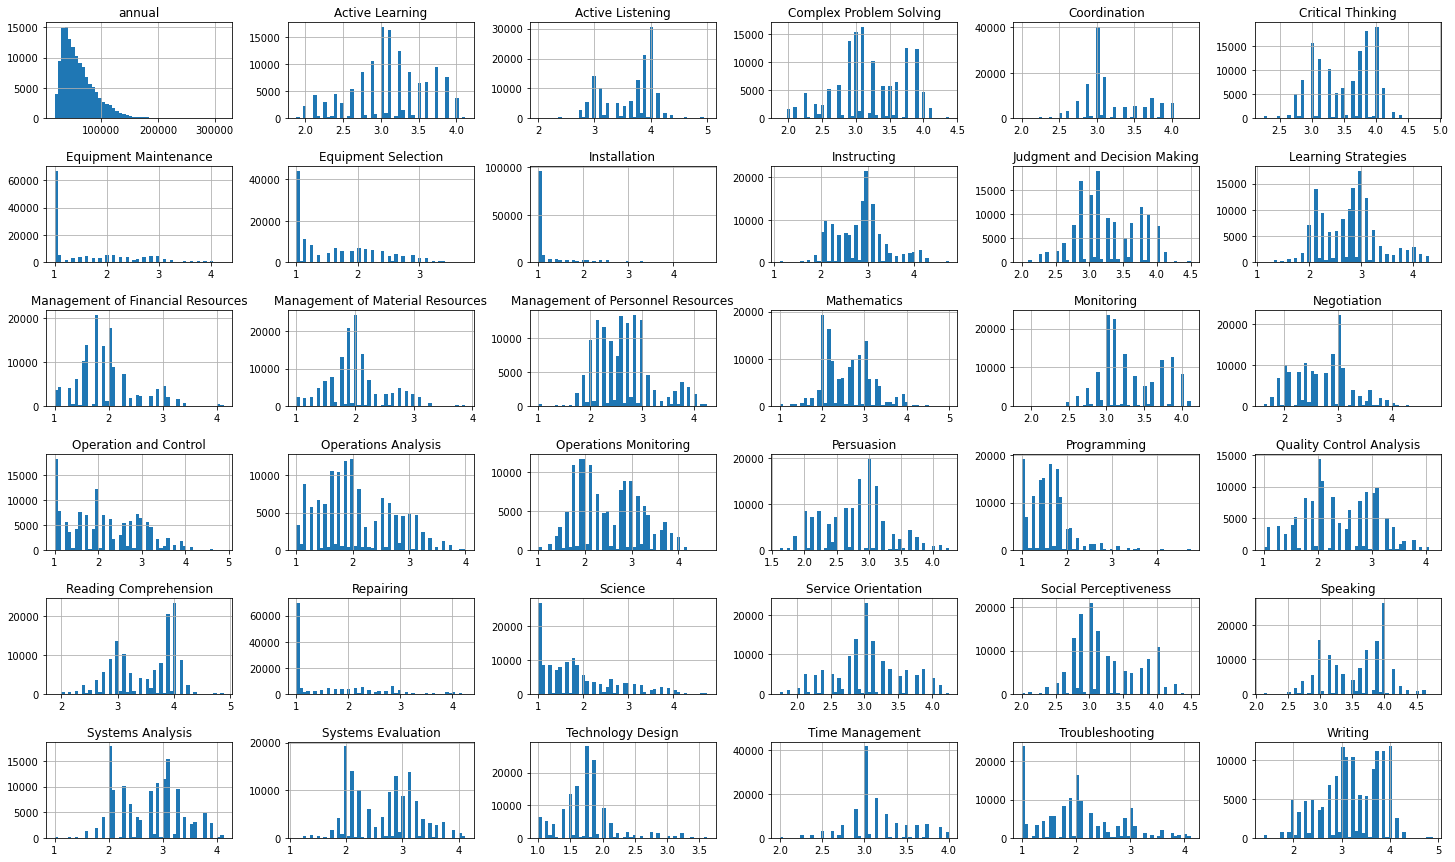

In [26]:
# Histograms of each variable in skills dataframe
df_pivot.hist(figsize=(25, 15), bins=50)
plt.subplots_adjust(hspace=0.5);

Just looking at these histograms, we can see that Installation, Equipment Maintenance, Equipment Selection, and Repairing are highly skewed to the right. Most of their values are concentrated around 1 so they don't seem very important for most occupations. I will remove these from our feature list later.

Most of the distributions above are bimodal. Time Managment and Service Orientation have the most normal distributions. Technology design and Programming have most of their values concentrated below 2. Science has a high value at 1 which means that science is not ranked as important for many occupations! We also see this features in Troubleshooting, Programming and Operations and Control.  

In [27]:
# Sort skills by median value in descending order
sorted_index = df.groupby('skill')[['importance']].median().sort_values('importance', ascending=False).index
sorted_index

Index(['Speaking', 'Active Listening', 'Critical Thinking',
       'Reading Comprehension', 'Writing', 'Monitoring',
       'Judgment and Decision Making', 'Social Perceptiveness',
       'Active Learning', 'Complex Problem Solving', 'Time Management',
       'Coordination', 'Service Orientation', 'Instructing',
       'Learning Strategies', 'Persuasion', 'Systems Evaluation',
       'Systems Analysis', 'Negotiation', 'Management of Personnel Resources',
       'Mathematics', 'Operations Monitoring', 'Quality Control Analysis',
       'Operations Analysis', 'Management of Material Resources',
       'Troubleshooting', 'Operation and Control',
       'Management of Financial Resources', 'Technology Design', 'Science',
       'Programming', 'Equipment Selection', 'Equipment Maintenance',
       'Repairing', 'Installation'],
      dtype='object', name='skill')

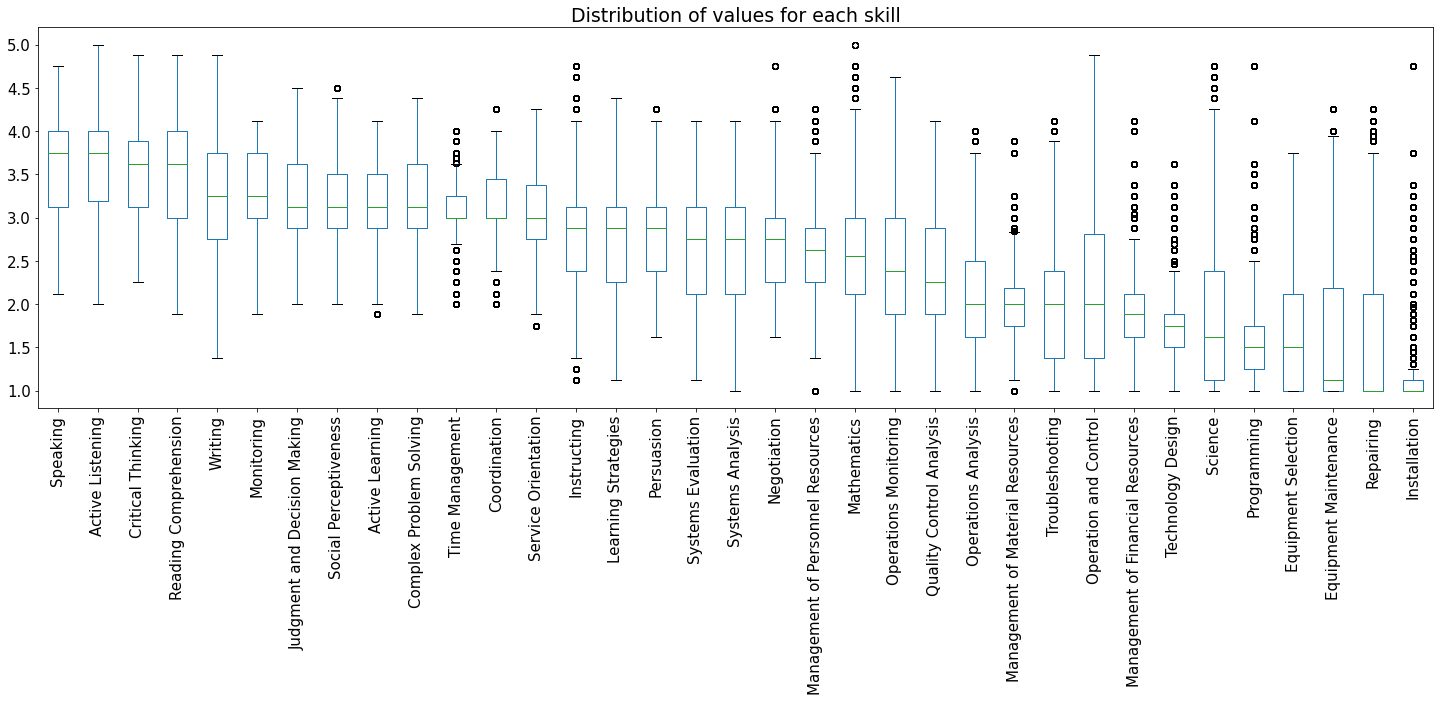

In [28]:
# Plot skills distributuion with boxplots in descending order
plt.subplots(figsize=(25,7))
df_pivot.drop(columns=['annual'])[sorted_index].boxplot(grid=False, fontsize=15)
plt.xticks(rotation=90)
plt.title('Distribution of values for each skill', fontsize=19);

From the boxplots we see that Installation is heavility concentrated at 1.0 with a very small range of values containted within the box and the whiskers of the plot with quite a few outliers. Equipment Selection, Equipment Maintenance, and Repairing seem to have a hight concentration of their values close to one (with IQR between 1 and 2). All of these skills are highly specialized. I will drop these and installation column later on.

Systems analysis and Systems Evaluations have almost identical boxplots and distributions, so we will look at their correlation as well. We will look at the correlation between these featurers later. 

Programming and technology design have very short IQR (~0.5) with most values below 2 with many high outliers, indicating they are specialized skills.

Time Managment values are concentrated around 3.0, indicating a narrow normal distirbution. The skills with the highest median scores include speaking, active listening, critical thinking, reading comprehension, and writing, all important skills for nearly all occupations.

# 5. Relationship between target feature (salary) and variables (skills)

In [29]:
# List of features(skills) to plot vs target feature(salary)
features = [x for x in df_pivot.columns]

In [30]:
len(features)

37

In [31]:
df_pivot.shape

(135989, 37)

In [32]:
# Function to create scatter plots
def scatterplots(columns, ncol=None, figsize=(10, 10)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False, sharex=True)
    fig.subplots_adjust(wspace=0.5, hspace=0.3)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sns.stripplot(x = col, y = 'annual', data=df_pivot, ax=ax, jitter=2, palette='BrBG')
        ax.set(xlabel=col, ylabel='Salary')
        ax.set_xticks([0,8.2, 16.4, 24.6, 32.8, 41]) # manually found, need to find better method 8.2 increments
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

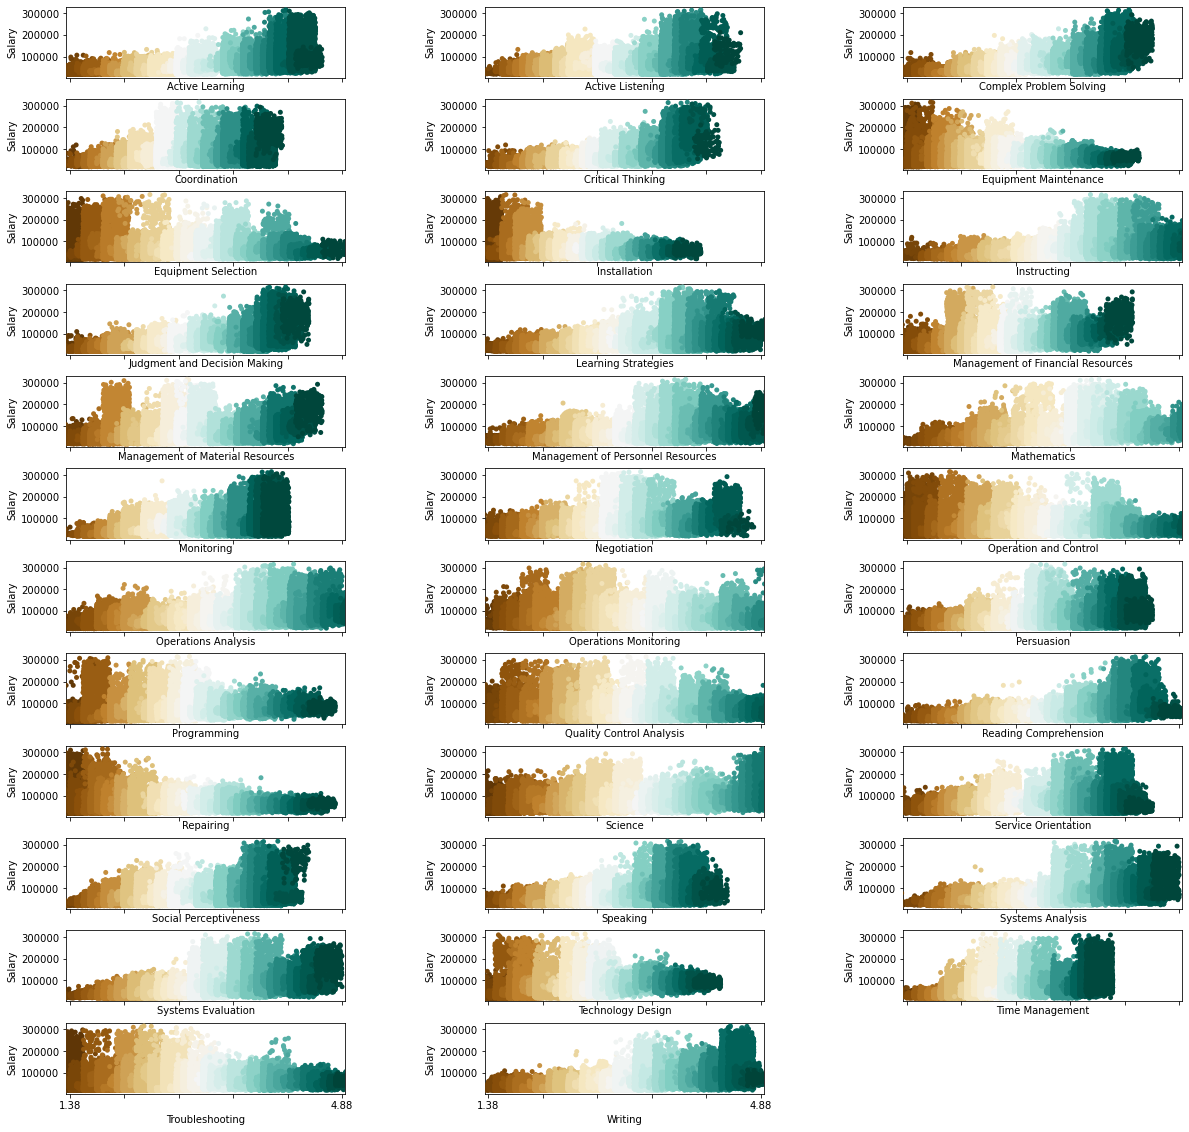

In [33]:
# Scatter plots of each skill vs salary
scatterplots(features[2:], ncol=3, figsize=(20, 20));

Equipment Maintenance, Repairing and Installation are negatively correlated with salary. 

Troubleshooting, Technology Design and Programming all also seem somewhat negatively correlated with salary.

Systems Analysis and Systems Evaluations have very similar plots.

All this is in agreement with observations from the boxplots and histograms we made about these skills above. 

# 6. Correlation between each feature

In [34]:
# Correlation matrix for skills
corr_matrix = df_pivot.corr()
corr_matrix.head()

skill,annual,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
skill,,,,,,,,,,,,,,,,,,,,,
annual,1.000000,0.628549,0.483260,0.667850,0.395357,0.674059,-0.158689,-0.079179,-0.066143,0.438350,...,0.524381,0.185079,0.345232,0.480268,0.638692,0.639100,0.388089,0.506858,-0.086262,0.569310
Active Learning,0.628549,1.000000,0.774675,0.845359,0.600212,0.855278,-0.312833,-0.225251,-0.132289,0.776351,...,0.560583,0.491206,0.636477,0.756948,0.772441,0.779124,0.420889,0.642525,-0.234832,0.827626
Active Listening,0.483260,0.774675,1.000000,0.714002,0.598085,0.778958,-0.554878,-0.494271,-0.336809,0.657559,...,0.372729,0.655352,0.740961,0.909480,0.630090,0.620634,0.245143,0.604084,-0.495910,0.830643
Complex Problem Solving,0.667850,0.845359,0.714002,1.000000,0.560268,0.881599,-0.216920,-0.129738,-0.045382,0.668027,...,0.598695,0.360050,0.522310,0.696423,0.846838,0.853739,0.548926,0.636601,-0.122821,0.792352
Coordination,0.395357,0.600212,0.598085,0.560268,1.000000,0.591681,-0.327124,-0.265178,-0.216885,0.655812,...,0.205837,0.593897,0.747286,0.646074,0.550979,0.580610,0.178169,0.715557,-0.242360,0.525125


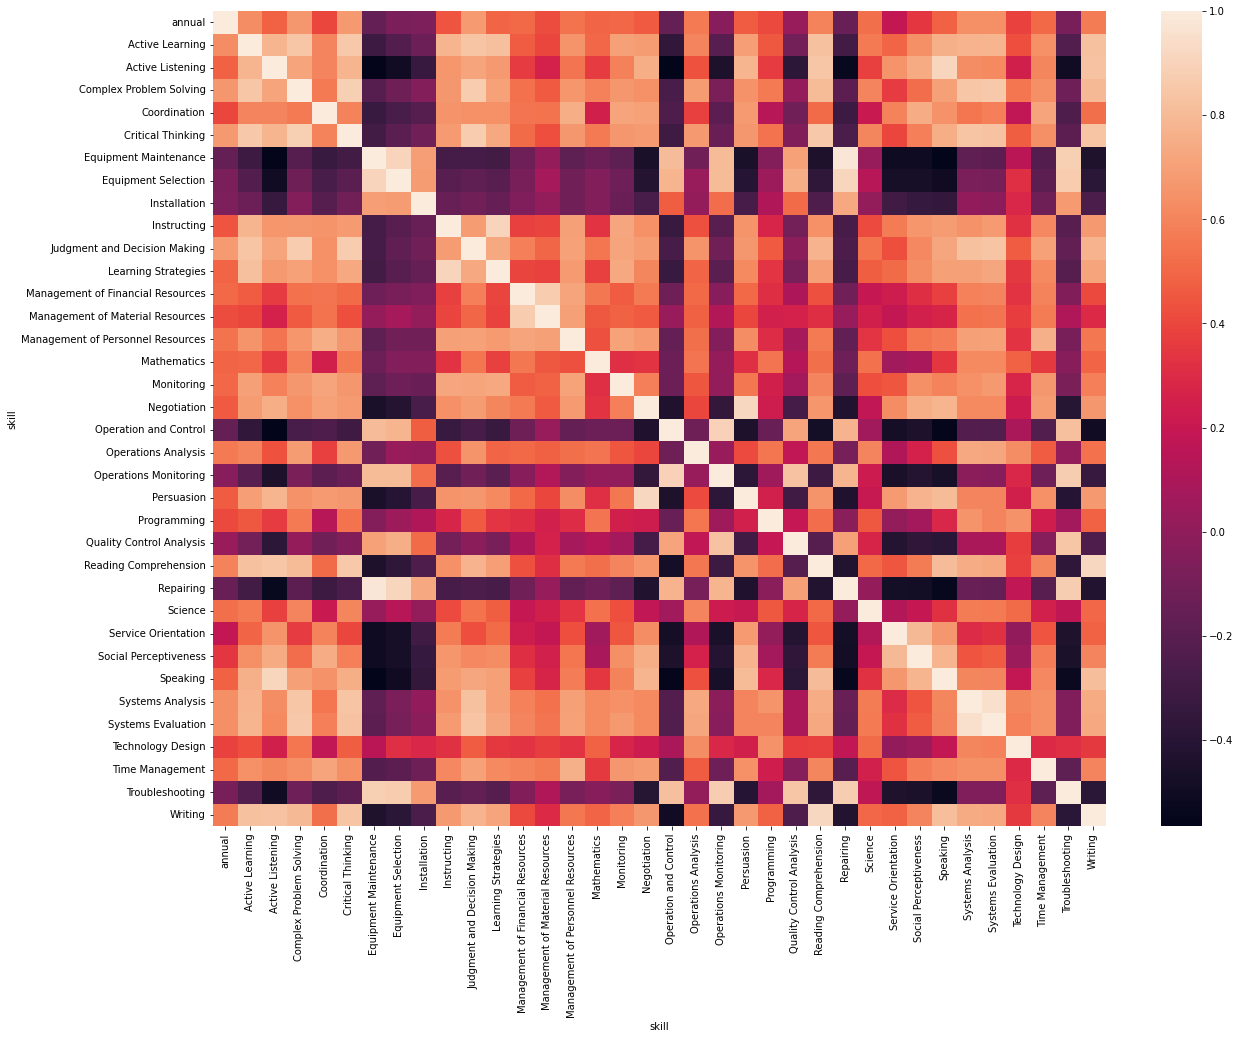

In [35]:
# Look at full heatmap of skills data
fig, ax=plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix);

There is a lot going on but we can see that once again the same skills (repairing, installation, equipment maintenance, equipment selection and troubleshooting negatively correlate with all other skills as well as with salary with high correlation among themselves.

## 6.1 Equipment-related skills

In [36]:
# Dataframe including skills related to intallation and maintaining equipment
equipment = df_pivot[['Installation', 'Repairing', 'Equipment Maintenance', 'Equipment Selection']]
equipment.head()

skill,Installation,Repairing,Equipment Maintenance,Equipment Selection
occupation,,,,
Accountants and Auditors,1.0,1.0,1.0,1.0
Accountants and Auditors,1.0,1.0,1.0,1.0
Accountants and Auditors,1.0,1.0,1.0,1.0
Accountants and Auditors,1.0,1.0,1.0,1.0
Accountants and Auditors,1.0,1.0,1.0,1.0


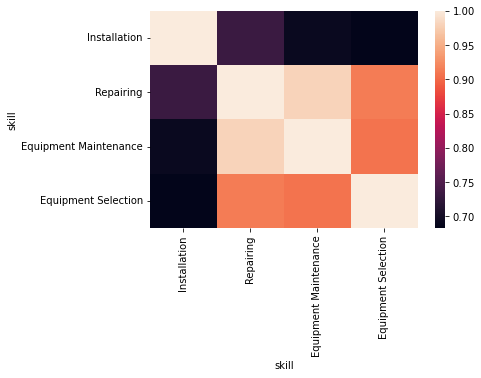

In [37]:
sns.heatmap(equipment.corr());

There is no clear correlation between Installation and the other 3. Instead we will drop Installations based on looking at it's distribution and boxplots above and concluding there is very little information here that could be relevent to a wide range of occupations.

Equipment maintanace and Repairing seem most correlated but there is a clear positive correlation among these features. From the overall heatmap, we can also see that these features have close to zero correlation, maybe even slightly neagtively correlated with salary, our target feature!

We will definately drop the skills installation, repairing, equipment maintenance and equipment selection later on.

## 6.2 Technology-related skills

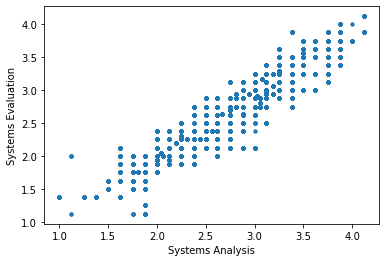

In [38]:
# Correlation between Systems Analysis and Systems Evaluation
plt.plot(df_pivot['Systems Analysis'], df_pivot['Systems Evaluation'], marker='.', linestyle='none')
plt.xlabel('Systems Analysis')
plt.ylabel('Systems Evaluation');

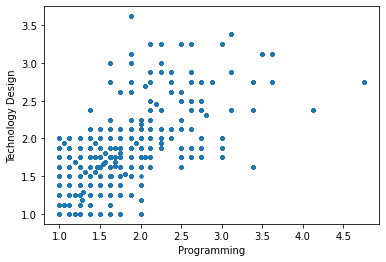

In [39]:
# Correlation between Programming and Technology Design
plt.plot(df_pivot['Programming'], df_pivot['Technology Design'], marker='.', linestyle='none')
plt.xlabel('Programming')
plt.ylabel('Technology Design');

## 6.3 Skills related to learning and problem solving

In [40]:
# Correlation among skills relevent to learning and decision making
learning_skills = df_pivot[['Critical Thinking', 'Complex Problem Solving', 'Active Learning', 
                          'Active Listening', 'Learning Strategies', 'Instructing', 'Judgment and Decision Making']]
learning_skills.head()

skill,Critical Thinking,Complex Problem Solving,Active Learning,Active Listening,Learning Strategies,Instructing,Judgment and Decision Making
occupation,,,,,,,
Accountants and Auditors,3.88,3.44,3.31,3.94,2.94,2.88,3.5
Accountants and Auditors,3.88,3.44,3.31,3.94,2.94,2.88,3.5
Accountants and Auditors,3.88,3.44,3.31,3.94,2.94,2.88,3.5
Accountants and Auditors,3.88,3.44,3.31,3.94,2.94,2.88,3.5
Accountants and Auditors,3.88,3.44,3.31,3.94,2.94,2.88,3.5


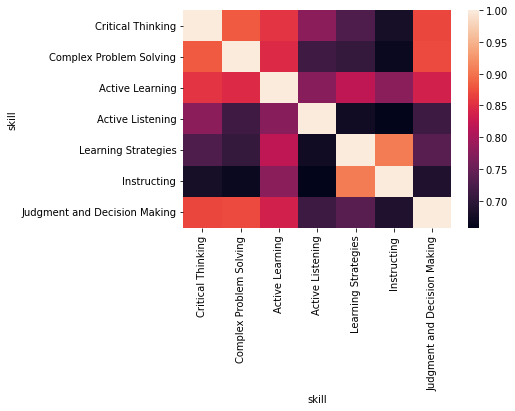

In [41]:
sns.heatmap(learning_skills.corr());

There is correlation among many skills as seen above. Let's run a PCA to find the ideal dimensions for the problem.

# 7. PCA analysis

In [42]:
new = df_pivot.drop(columns=['state', 'annual'])
skills_pca=PCA().fit(new)

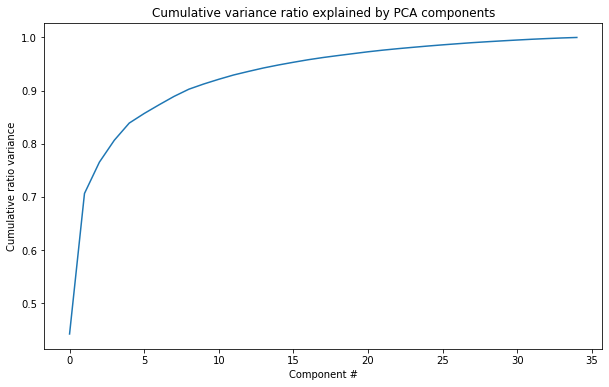

In [43]:
plt.subplots(figsize=(10, 6))
plt.plot(skills_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components');

Around 85 percent of variance is explained by the first 5 pca components and around 90 percent by the first pca 8 components.

In [44]:
skills_pca_x = skills_pca.transform(new)

In [45]:
skills_pca_x.shape

(135989, 35)

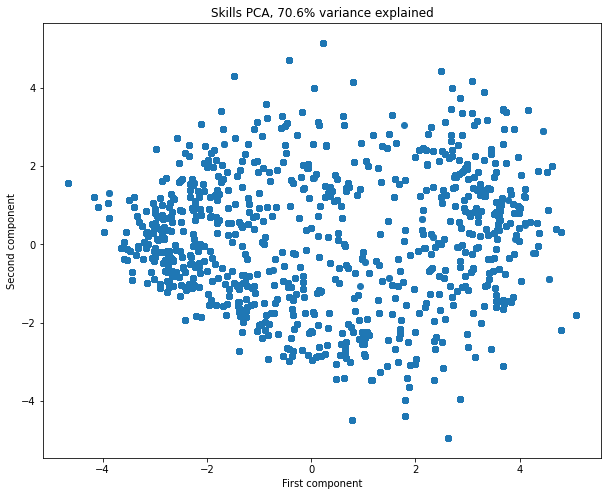

In [46]:
x = skills_pca_x[:, 0]
y = skills_pca_x[:, 1]
pc_var = 100 * skills_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Skills PCA, {pc_var:.1f}% variance explained');

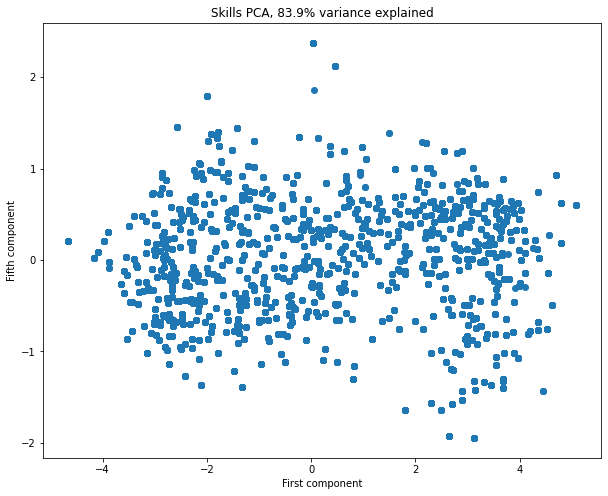

In [47]:
x = skills_pca_x[:, 0]
y = skills_pca_x[:, 4]
pc_var = 100 * skills_pca.explained_variance_ratio_.cumsum()[4]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Fifth component')
plt.title(f'Skills PCA, {pc_var:.1f}% variance explained');

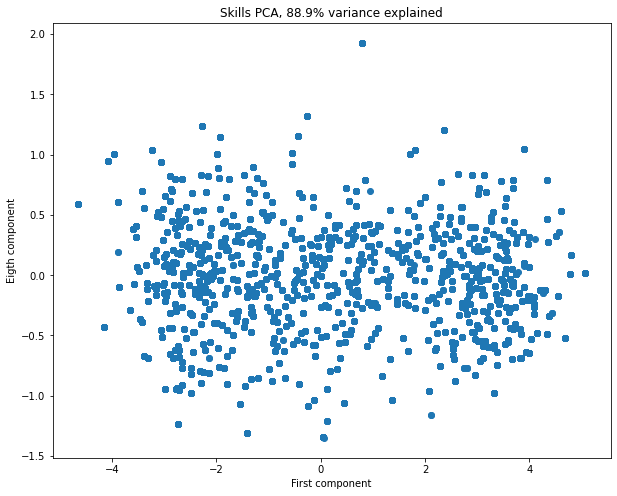

In [48]:
x = skills_pca_x[:, 0]
y = skills_pca_x[:, 7]
pc_var = 100 * skills_pca.explained_variance_ratio_.cumsum()[7]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Eigth component')
plt.title(f'Skills PCA, {pc_var:.1f}% variance explained');

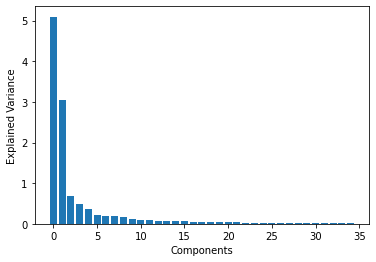

In [49]:
features=range(skills_pca.n_components_)
plt.bar(features, skills_pca.explained_variance_)
plt.xlabel('Components')
plt.ylabel('Explained Variance');